In [1]:
#####Latent Gamma regression with Gibbs sampling#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import calendar
from datetime import datetime
from datetime import timedelta
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [3]:
####データの生成####
##データの設定
k = 5
hh = 3000
Lambda = np.random.gamma(30, 1/0.25, hh)
pt = np.random.poisson(Lambda, hh)
hhpt = np.sum(pt)
k_vec = np.repeat(1.0, k)

In [4]:
##IDとインデックスの定義
#IDの定義
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [5]:
##入力と応答変数を生成
mag1 = 15; mag2 = 20

while True:
    #素性ベクトルを生成
    k1 = 3; k2 = 5; k3 = 5
    x1 = np.abs(np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1)))
    x2 = np.zeros((hhpt, k2))
    for j in range(k2):
        prob = np.random.uniform(0.25, 0.55, 1)
        x2[:, j] = np.random.binomial(1, prob, hhpt)
    x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
    x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
    x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)
    col = x.shape[1]

    #モデルパラメータを生成
    
    theta = np.random.dirichlet(np.repeat(0.25, k), hh)
    beta0 = np.random.gamma(np.random.uniform(0.5, 100.0, k), 1/1.0, k)
    beta1 = np.array([np.abs(np.random.normal(beta0[j] / mag1, beta0[j] / mag2, col-1)) for j in range(k)])
    beta = np.hstack((beta0[:, np.newaxis], beta1))
    phi = np.random.normal(0.0, 0.75, k)
    kappa = np.exp(phi)
    beta = np.hstack((beta0[:, np.newaxis] , beta1))
    thetat = theta.copy(); betat = beta.copy(); phit = phi.copy()

    #ガンマ分布から応答変数を生成
    z, Z = rmnom(theta[d_id, ], hhpt, k, 1)   #トピックを生成
    mu1 = np.dot(x * beta[z, ], np.repeat(1.0, col))
    mu2 = beta0[z, ]
    y1 = np.random.gamma(np.exp(kappa)[z], mu1, hhpt)
    y2 = np.random.gamma(np.exp(kappa)[z], mu2, hhpt)
    y_log1 = np.log(y1)
    y_log2 = np.log(y2)

    #break条件
    if np.max(y1) < 1000:
        break

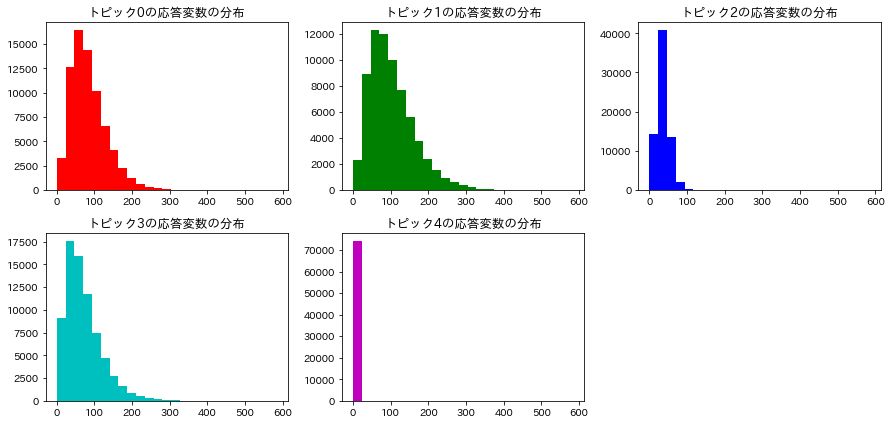

In [6]:
#生成したデータを可視化
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(k):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(y1[z==j],  bins=25, range=(0, np.max(y1)), color=colorlist[j])
    plt.title("トピック" + str(j) + "の応答変数の分布", fontsize=12.5)
fig.tight_layout()
plt.show()

In [7]:
####ギブスサンプリングでパラメータをサンプリング####
##ガンマ分布のパラメータを推定するための関数
#モデルの対数事後分布を定義
def loglike(phi, mu, delta, tau, y, y_log, index_z, k):
    #パラメータを定義
    kappa = np.exp(phi)
    
    #対数事後分布の和
    Posterior = np.repeat(0.0, k)
    for j in range(k):
        index = index_z[j] 
        inv_Lambda = 1 / mu[index]
        Lho = np.sum(kappa[j]*np.log(inv_Lambda) - scipy.special.loggamma(kappa[j]) + (kappa[j]-1)*y_log[index] - inv_Lambda*y[index])
        Prior = -1/2 * np.power(phi[j] - delta, 2) / tau
        Posterior[j] = Lho + Prior
    return Posterior

#形状パラメータの勾配ベクトル
def dll_kappa(phi, mu, delta, tau, y, y_log, index_z, k):
    #パラメータを定義
    kappa = np.exp(phi)

    #勾配ベクトルの和
    gradient = np.repeat(0.0, k)
    for j in range(k):
        index = index_z[j]
        inv_Lambda = 1 / mu[index]
        dll = np.sum(np.log(inv_Lambda) - scipy.special.digamma(kappa[j]) + y_log[index])
        dmv = -(phi[j] - delta) / tau
        gradient[j] = -(dll + dmv)
    return gradient

#リープフロッグ法を解く関数
def leapfrog_kappa(r, z1, D, e, L): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, mu, delta, tau, y1, y_log1, index_z, k) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, mu, delta, tau, y1, y_log1, index_z, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [8]:
##アルゴリズムの設定
#MCMCの設定
R = 1000
keep = 2
burnin = 250
iter = 0
disp = 10
e = 0.00025
L = 5

#事前分布の設定
alpha = 0.25
delta = -1.0
tau = 0.01
s0 = np.append(1.0, np.repeat(0.25, col-1))
v0 = np.append(1.0, np.repeat(0.25, col-1))

In [9]:
##パラメータの真値
#トピック分布の真値
theta = thetat.copy()
Zi = Z.copy()
z = np.dot(Zi, np.arange(k))
index_z = [np.array(np.where(Zi[:, j])[0], dtype="int") for j in range(k)]

#モデルパラメータの真値
beta = betat.copy()
phi = phit.copy()
kappa = np.exp(phi)

#期待値の真値
mu = np.dot(x * beta[z, ], np.repeat(1.0, col))
mut = np.dot(x, beta.T)

In [10]:
##パラメータの初期値
#トピック分布の初期値
theta = np.random.dirichlet(np.repeat(1.0, k), hh)
z, Zi = rmnom(theta[d_id, ], hhpt, k, 1)
index_z = [np.array(np.where(Zi[:, j])[0], dtype="int") for j in range(k)]

#モデルパラメータの初期値
beta0 = np.mean(y1) + np.random.normal(0, 5.0, k)
beta1 = np.random.gamma(1.0, 1/1.0, k*(col-1)).reshape(k, col-1)
beta = np.hstack((beta0[:, np.newaxis], beta1))
phi = np.repeat(0.5, k)
kappa = np.exp(phi)

#期待値の初期値
mu = np.dot(x * beta[z, ], np.repeat(1.0, col))

In [11]:
##パラメータの格納用配列
#モデルパラメータの格納用配列
THETA = np.zeros((hh, k, int(R/keep)))
BETA = np.zeros((k, col, int(R/keep)))
PHI = np.zeros((int(R/keep), k))

#トピックの格納用配列
SEG = np.zeros((hhpt, k))

In [12]:
##対数尤度の基準値
#真値での対数尤度
Posterior = thetat[d_id, ] * np.array([scipy.stats.gamma.pdf(y1, np.exp(phit[j]), scale=mut[:, j]) for j in range(k)]).T
LLbest = np.sum(np.log(np.sum(Posterior, axis=1)))
print(LLbest)

-2049690.2758677206


In [13]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##潜在変数zをサンプリング
    #事後分布から割当確率を定義
    mu_vec = np.dot(x, beta.T)
    Posterior = theta[d_id, ] * np.array([scipy.stats.gamma.pdf(y1, kappa[j], scale=mu_vec[:, j]) for j in range(k)]).T
    Prob = Posterior / np.dot(Posterior, k_vec)[:, np.newaxis]

    #多項分布からトピックをサンプリング
    z, Zi = rmnom(Prob, hhpt, k, 1)
    topic_n = np.sum(Zi, axis=0)
    index_z = [np.array(np.where(Zi[:, j])[0], dtype="int") for j in range(k)]


    ##トピック分布をサンプリング
    #ディリクリ分布のパラメータ
    wsums = np.zeros((hh, k))
    for i in range(hh):
        wsums[i, ] = np.sum(Zi[d_list[i], ], axis=0) + alpha
        theta[i, ] = np.random.dirichlet(wsums[i, ], 1).reshape(-1)


    ##回帰係数をサンプリング
    #補助変数を更新
    mu_deploy = x * beta[z, ]
    mu = np.sum(mu_deploy, axis=1)
    Lambda = mu_deploy / mu[:, np.newaxis]

    #ガンマ分布からパラメータをサンプリング
    for j in range(k):
        index = index_z[j]
        s = np.sum(y1[index, np.newaxis] * Lambda[index, ] , axis=0) + s0
        v = kappa[j] * np.sum(x[index, ], axis=0) + v0
        beta[j, ] = np.random.gamma(s, 1/v, col)


    ##形状パラメータをサンプリング
    #リープフロッグ法で新しいパラメータをサンプリング
    rold = np.random.normal(0, 1.0, k)
    phid = phi.copy()
    res = leapfrog_kappa(rold, phid, dll_kappa, e, L)
    rnew = res[0]
    phin = res[1]

    #移動前と移動後のハミルトニアン
    Hnew = -loglike(phin, mu, delta, tau, y1, y_log1, index_z, k)
    Hold = -loglike(phid, mu, delta, tau, y1, y_log1, index_z, k)

    #新しいパラメータを採択
    rand = np.random.uniform(0, 1, k)
    gamma = np.exp(Hold - Hnew); gamma[gamma > 1.0] = 1.0
    accept_prob = gamma.copy()
    flag = np.array(gamma > rand, dtype="int")
    phi = flag*phin + (1-flag)*phid
    kappa = np.exp(phi)


    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA[:, :, mkeep] = theta
        BETA[:, :, mkeep] = beta
        PHI[mkeep, ] = phi 

    #トピックを格納
    if (rp%keep==0) & (burnin >= rp):
        SEG += Zi

    #対数尤度の更新とサンプリング結果の表示
    if rp%disp==0:
        #対数尤度を更新
        LL = np.sum(np.log(np.sum(Posterior, axis=1)))

        #サンプリング結果の表示
        print(rp)
        print(np.round(accept_prob, 3))
        print(np.round(np.exp(phi), 3))
        print(np.round([LL, LLbest], 1))

0
[1. 1. 1. 1. 1.]
[1.591 1.589 1.591 1.588 1.586]
[-1910170.7 -2049690.3]
10
[1. 1. 1. 1. 1.]
[1.407 1.551 1.546 1.577 1.457]
[-1804018.9 -2049690.3]
20
[1. 1. 1. 1. 1.]
[1.407 1.614 1.613 1.647 1.478]
[-1760666.8 -2049690.3]
30
[1. 1. 1. 1. 1.]
[1.549 1.683 1.659 1.728 1.549]
[-1752474.9 -2049690.3]
40
[1. 1. 1. 1. 1.]
[1.692 1.752 1.713 1.792 1.628]
[-1747733.9 -2049690.3]
50
[1. 1. 1. 1. 1.]
[1.829 1.82  1.756 1.852 1.711]
[-1743918.1 -2049690.3]
60
[1. 1. 1. 1. 1.]
[1.974 1.868 1.8   1.903 1.802]
[-1740686.7 -2049690.3]
70
[1. 1. 1. 1. 1.]
[2.111 1.919 1.837 1.968 1.884]
[-1738008.1 -2049690.3]
80
[1.    1.    0.304 1.    1.   ]
[2.232 1.96  1.88  2.026 1.964]
[-1735767.5 -2049690.3]
90
[1.    1.    0.298 1.    1.   ]
[2.344 1.999 1.902 2.075 2.043]
[-1733815.8 -2049690.3]
100
[1. 1. 1. 1. 1.]
[2.458 2.036 1.931 2.125 2.129]
[-1732100.5 -2049690.3]
110
[1. 1. 1. 1. 1.]
[2.556 2.07  1.965 2.165 2.205]
[-1730635.  -2049690.3]
120
[1. 1. 1. 1. 1.]
[2.655 2.119 1.997 2.203 2.262]
[-17

920
[1.   1.   1.   0.65 1.  ]
[4.912 2.848 2.483 2.968 5.095]
[-1714810.4 -2049690.3]
930
[0.805 0.773 1.    0.912 1.   ]
[4.9   2.849 2.474 2.962 5.103]
[-1714937.4 -2049690.3]
940
[0.59  0.908 1.    0.631 0.477]
[4.896 2.849 2.464 2.953 5.122]
[-1714847.3 -2049690.3]
950
[0.82  0.592 0.905 0.843 0.088]
[4.898 2.854 2.467 2.952 5.138]
[-1714771.5 -2049690.3]
960
[1.    1.    1.    1.    0.518]
[4.91  2.859 2.469 2.961 5.159]
[-1714676.5 -2049690.3]
970
[0.572 1.    0.876 0.998 1.   ]
[4.924 2.856 2.464 2.967 5.15 ]
[-1714683.9 -2049690.3]
980
[0.893 1.    1.    0.713 1.   ]
[4.928 2.873 2.459 2.963 5.181]
[-1714680.2 -2049690.3]
990
[1.    0.812 1.    0.407 1.   ]
[4.927 2.88  2.455 2.962 5.212]
[-1714705.7 -2049690.3]
